# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import xgboost as xgb

# Import Data

In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df['Survived'] = df['Survived'].astype('int64')
df['PassengerId'] = df['PassengerId'].astype('category')
df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

# Feature Selection

In [4]:
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']
target = 'Survived'

# Train Test Split

In [5]:
X = df[numerical_features + categorical_features]
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Outlier Removal

In [7]:
# only on the training set!!! But we won't use it on this dataset

# Numerical Transformations

For the numerical columns we impute missing values with the mean and scale using the standar scaler method

In [8]:
numeric_transformer = Pipeline(steps=[
    ('mean_imputer', SimpleImputer(strategy='mean')),  # Impute with mean
    ('scaler', StandardScaler())  # Scale with StandardScaler
])

# Categorical Transformations

For the categorical columns we impute the missing values with the most frequent value and perform one hot enconding on the categorical columns

In [9]:
categorical_transformer = Pipeline(steps=[
    ('most_frequent_imputer', SimpleImputer(strategy='most_frequent')),  # Impute with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encoding
])

# Preprocessing Pipeline

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_transformer', numeric_transformer, numerical_features),
        ('cat_transformer', categorical_transformer, categorical_features)
    ])

# Modeling Functions

In [11]:
def show_results(y_pred):    
    # 1. Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # 2. Classification Report (Precision, Recall, F1-Score, Support)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 3. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualize Confusion Matrix using Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # 4. Precision, Recall, F1-Score (Bar Chart)
    # Extract precision, recall, and F1 scores from classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = report['1']  # Or you can use 'macro avg' or other types
    
    # Plot Precision, Recall, F1-Score
    metrics_data = {
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1-score']
    }
    
    # Create bar chart for the metrics
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(metrics_data.keys()), y=list(metrics_data.values()))
    plt.title("Precision, Recall, F1-Score")
    plt.ylabel("Score")
    plt.ylim(0, 1)  # Limit y-axis to 0-1
    plt.show()

In [12]:
report_ac = {}

# Modeling Parametrizations

In [13]:
metric_to_optimize = 'f1'

# Naive Bayes

In [14]:
nb_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [15]:
# we need to add the classifier__ to denote the parameter of the classifier in the pipeline
param_grid = {
    'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # smoothing values to avoid division by zero
}

grid_search_nb = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid,
    cv=5,
    scoring=metric_to_optimize,
    n_jobs=-1,
    verbose=1
)

In [16]:
grid_search_nb.fit(X_train, y_train)

nb_model = grid_search_nb.best_estimator_

y_pred_nb = nb_model.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [17]:
accuracy = accuracy_score(y_test, y_pred_nb)
report = classification_report(y_test, y_pred_nb, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Naive Bayes'] = report

{'precision': 0.7, 'recall': 0.7313432835820896, 'f1-score': 0.7153284671532847, 'support': 67.0, 'accuracy': 0.7821229050279329}


Accuracy: 0.7821

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       112
           1       0.70      0.73      0.72        67

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



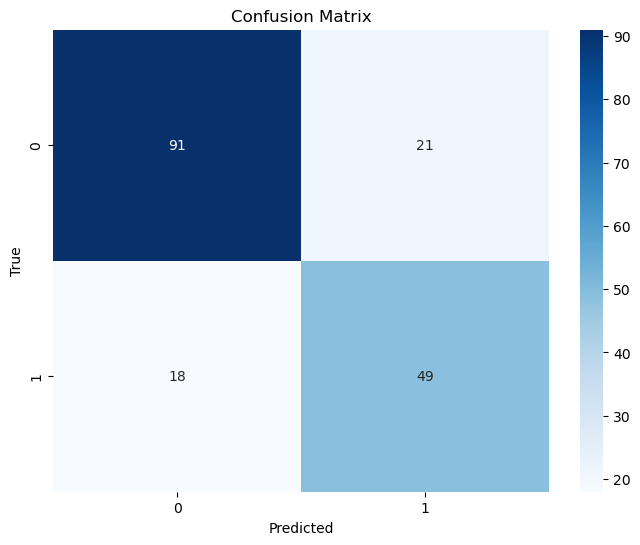

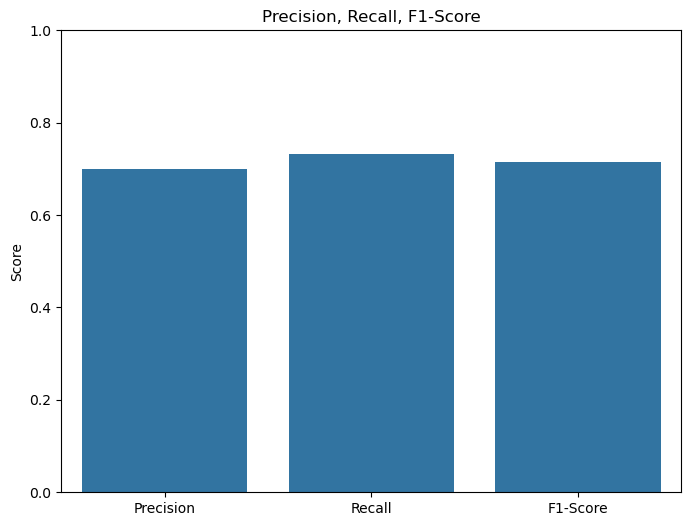

In [18]:
show_results(y_pred_nb)

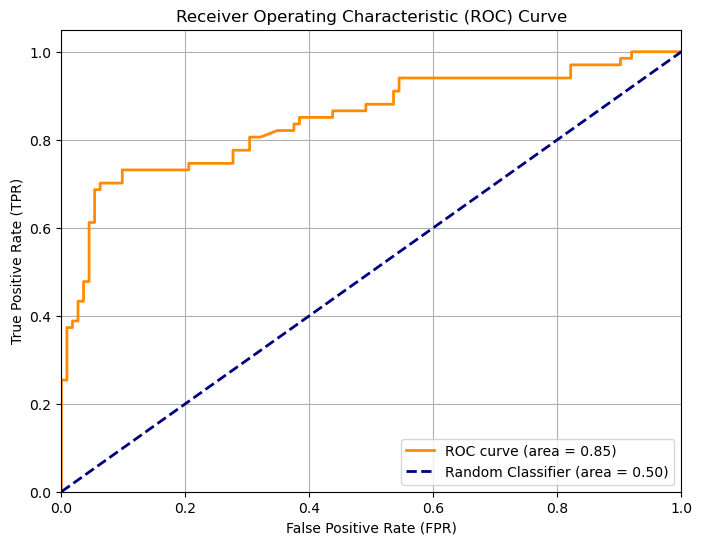

The AUC for the Naive Bayes Classifier is: 0.8475


In [19]:
y_pred_prob = nb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"The AUC for the Naive Bayes Classifier is: {roc_auc:.4f}")

In [20]:
# Calculate Youden's J statistic (TPR - FPR)
j_scores = tpr - fpr

# Find the index of the best threshold (maximum J score)
best_threshold_index = np.argmax(j_scores)

# The best threshold based on Youden's J
best_threshold = thresholds[best_threshold_index]
print(f"Best Threshold based on Youden's J statistic: {best_threshold}")

Best Threshold based on Youden's J statistic: 0.8980346368650641


# Logistic Regression

In [21]:
logreg_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [22]:
# we need to add the classifier__ to denote the parameter of the classifier in the pipeline
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],            # Inverse of regularization strength
    'classifier__penalty': ['l2'],                       # L2 regularization (common with 'lbfgs')
    'classifier__solver': ['lbfgs'],                     # Solver that supports L2
}

grid_search_logreg = GridSearchCV(
    estimator=logreg_model,
    param_grid=param_grid,
    cv=5,
    scoring=metric_to_optimize,
    n_jobs=-1,
    verbose=1
)

In [23]:
grid_search_logreg.fit(X_train, y_train)

logreg_model = grid_search_logreg.best_estimator_

y_pred_logreg = logreg_model.predict(X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [24]:
accuracy = accuracy_score(y_test, y_pred_logreg)
report = classification_report(y_test, y_pred_logreg, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Logistic Regression'] = report

{'precision': 0.7868852459016393, 'recall': 0.7164179104477612, 'f1-score': 0.75, 'support': 67.0, 'accuracy': 0.8212290502793296}


Accuracy: 0.8212

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       112
           1       0.79      0.72      0.75        67

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



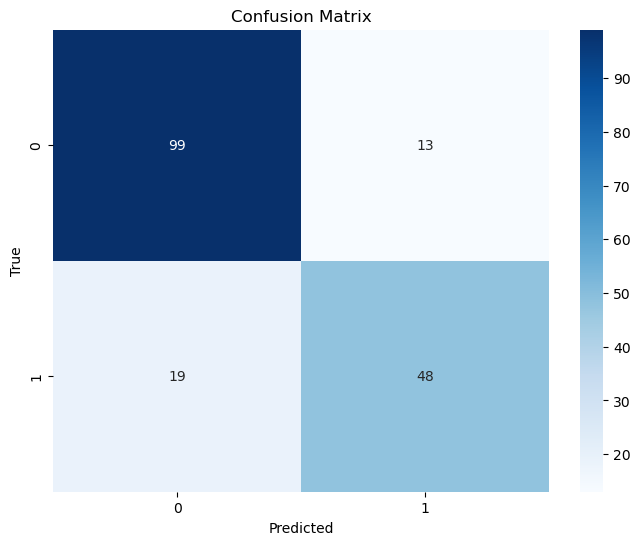

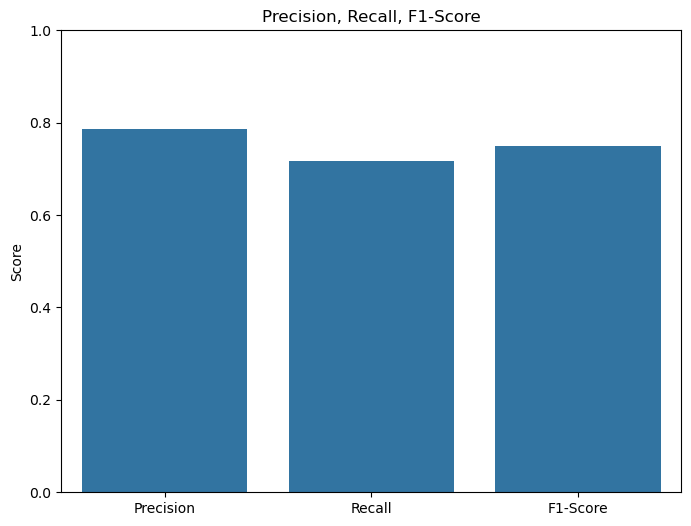

In [25]:
show_results(y_pred_logreg)

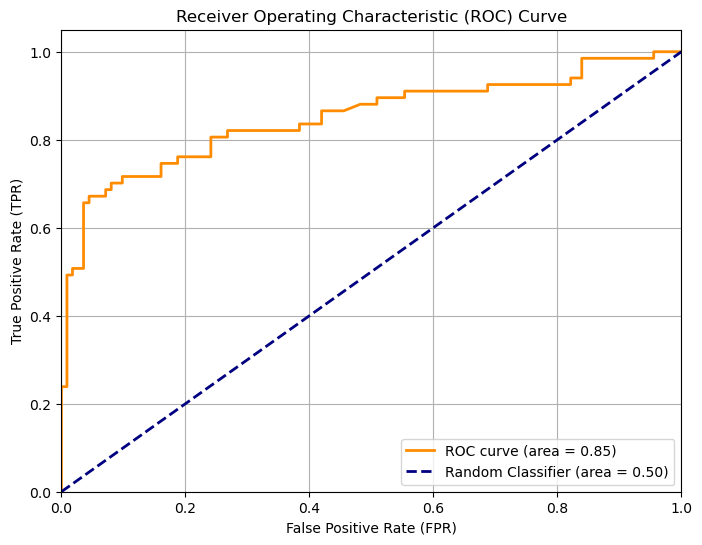

The AUC for the Logistic Regression Classifier is: 0.8499


In [26]:
y_pred_prob = logreg_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"The AUC for the Logistic Regression Classifier is: {roc_auc:.4f}")

In [27]:
# Calculate Youden's J statistic (TPR - FPR)
j_scores = tpr - fpr

# Find the index of the best threshold (maximum J score)
best_threshold_index = np.argmax(j_scores)

# The best threshold based on Youden's J
best_threshold = thresholds[best_threshold_index]
print(f"Best Threshold based on Youden's J statistic: {best_threshold}")

Best Threshold based on Youden's J statistic: 0.6494902101745428


# Decision Tree

In [28]:
dt_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [29]:
# we need to add the classifier__ to denote the parameter of the classifier in the pipeline
param_grid = {
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,                
    scoring=metric_to_optimize,  
    n_jobs=-1,           
    verbose=1
)

In [30]:
grid_search_dt.fit(X_train, y_train)

dt_model = grid_search_dt.best_estimator_

y_pred_dt = dt_model.predict(X_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [31]:
accuracy = accuracy_score(y_test, y_pred_dt)
report = classification_report(y_test, y_pred_dt, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Decision Tree'] = report

{'precision': 0.7878787878787878, 'recall': 0.7761194029850746, 'f1-score': 0.7819548872180451, 'support': 67.0, 'accuracy': 0.8379888268156425}


Accuracy: 0.8380

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       112
           1       0.79      0.78      0.78        67

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



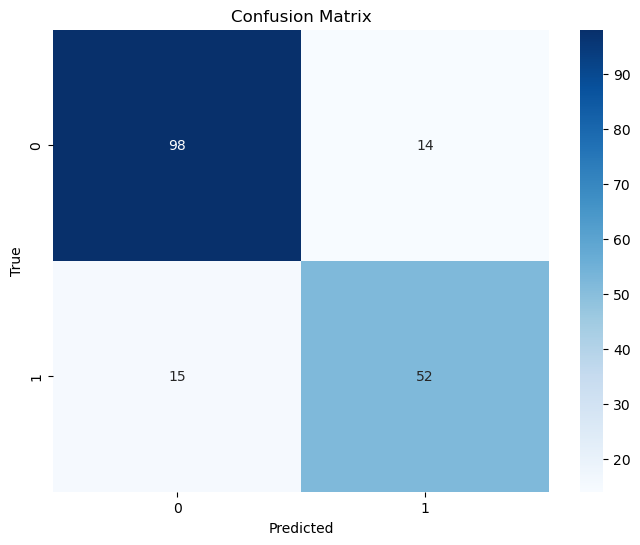

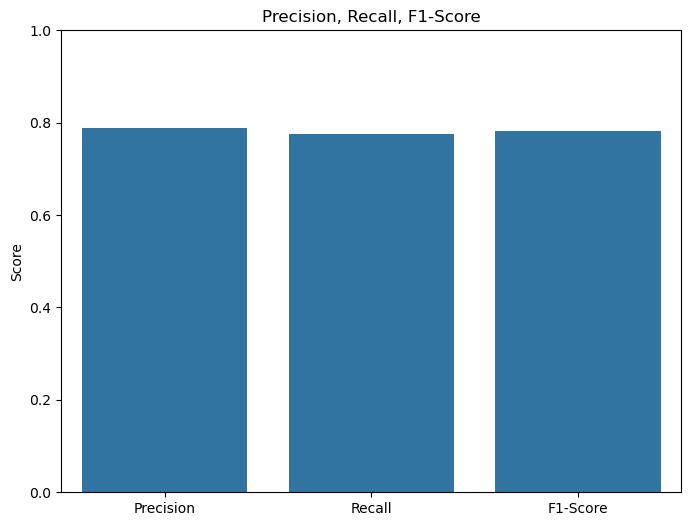

In [32]:
show_results(y_pred_dt)

In [33]:
feature_importances= dt_model.named_steps['classifier'].feature_importances_
features_names = dt_model.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                        Feature  Importance
8     cat_transformer__Sex_male    0.362954
3         num_transformer__Fare    0.199513
0          num_transformer__Age    0.192701
6     cat_transformer__Pclass_3    0.103000
1        num_transformer__SibSp    0.050491
4     cat_transformer__Pclass_1    0.046367
2        num_transformer__Parch    0.025748
11  cat_transformer__Embarked_S    0.009641
10  cat_transformer__Embarked_Q    0.009585
5     cat_transformer__Pclass_2    0.000000
7   cat_transformer__Sex_female    0.000000
9   cat_transformer__Embarked_C    0.000000


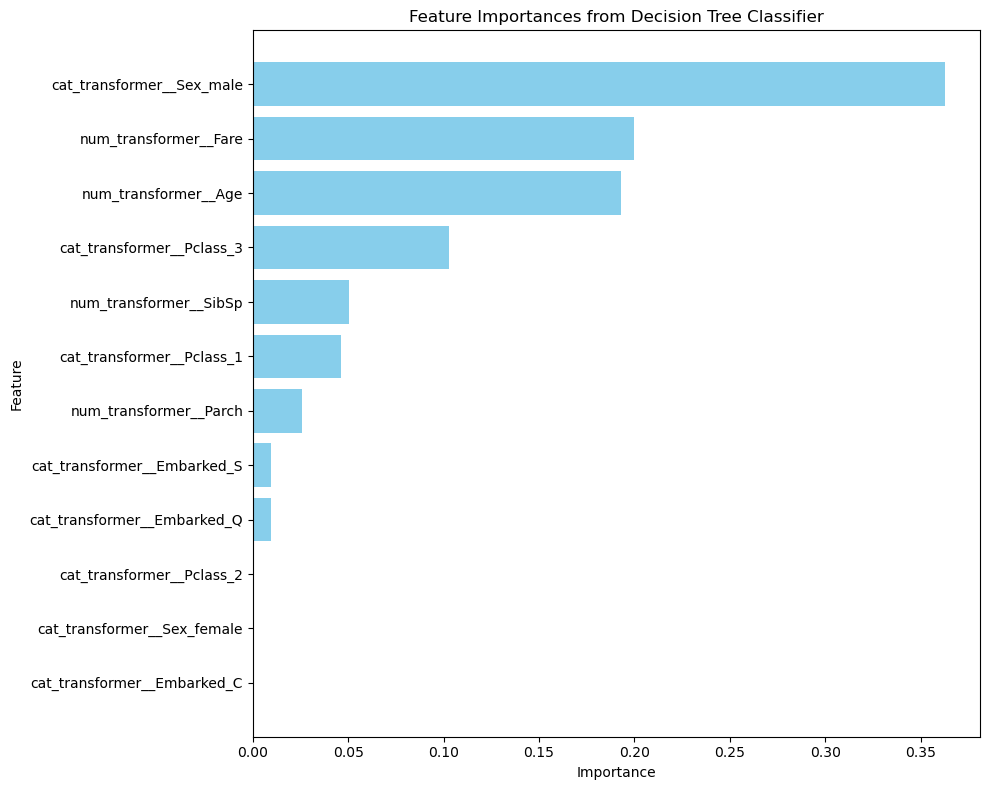

In [34]:
# Plotting the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Classifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.tight_layout()

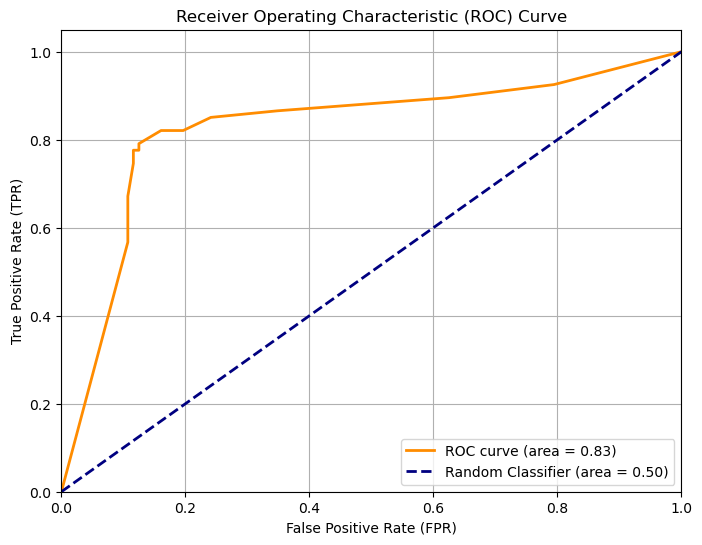

The AUC for the Decision Tree Classifier is: 0.8269


In [35]:
y_pred_prob = dt_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"The AUC for the Decision Tree Classifier is: {roc_auc:.4f}")

In [36]:
# Calculate Youden's J statistic (TPR - FPR)
j_scores = tpr - fpr

# Find the index of the best threshold (maximum J score)
best_threshold_index = np.argmax(j_scores)

# The best threshold based on Youden's J
best_threshold = thresholds[best_threshold_index]
print(f"Best Threshold based on Youden's J statistic: {best_threshold}")

Best Threshold based on Youden's J statistic: 0.5


# Random Forest

In [37]:
rf_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [38]:
# we need to add the classifier__ to denote the parameter of the classifier in the pipeline
param_grid = {
    'classifier__n_estimators': [100, 200],               # Number of trees
    'classifier__max_depth': [None, 10, 20],              # Max depth of the tree
    'classifier__min_samples_split': [2, 5],              # Min samples to split an internal node
    'classifier__min_samples_leaf': [1, 2],               # Min samples at a leaf node
    'classifier__max_features': ['sqrt', 'log2'],         # Number of features to consider at each split
}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring=metric_to_optimize,
    n_jobs=-1,
    verbose=1
)

In [39]:
grid_search_rf.fit(X_train, y_train)

rf_model = grid_search_rf.best_estimator_

y_pred_rf = rf_model.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [40]:
accuracy = accuracy_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['Random Forest'] = report

{'precision': 0.7878787878787878, 'recall': 0.7761194029850746, 'f1-score': 0.7819548872180451, 'support': 67.0, 'accuracy': 0.8379888268156425}


Accuracy: 0.8380

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       112
           1       0.79      0.78      0.78        67

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



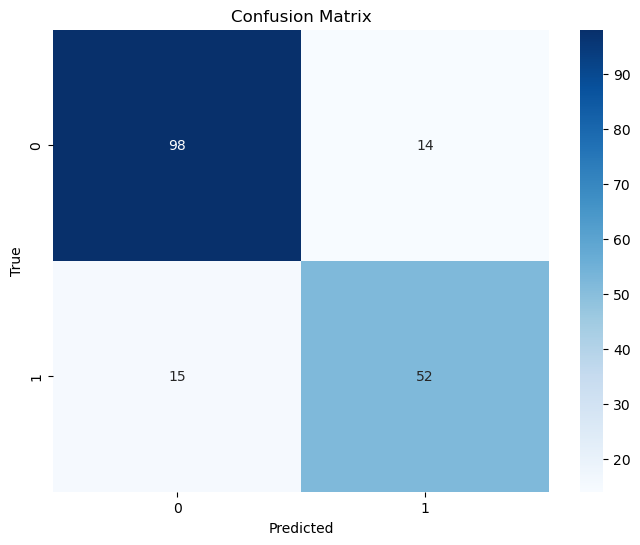

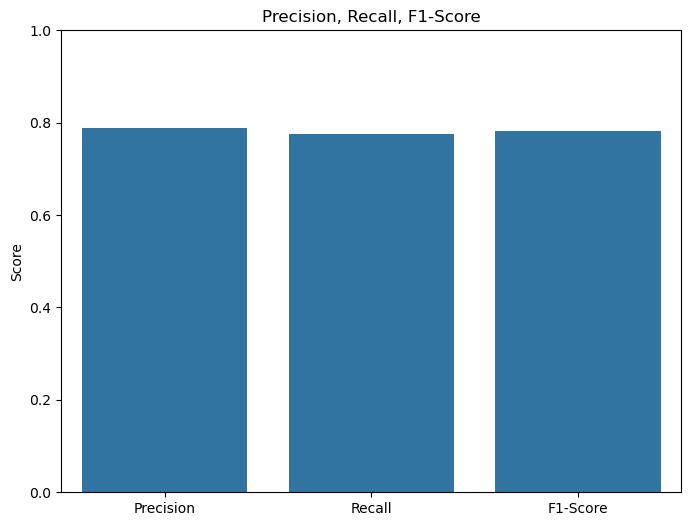

In [41]:
show_results(y_pred_rf)

In [42]:
feature_importances= rf_model.named_steps['classifier'].feature_importances_
features_names = rf_model.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                        Feature  Importance
3         num_transformer__Fare    0.240139
0          num_transformer__Age    0.214633
7   cat_transformer__Sex_female    0.176971
8     cat_transformer__Sex_male    0.147461
6     cat_transformer__Pclass_3    0.055893
2        num_transformer__Parch    0.041086
1        num_transformer__SibSp    0.040530
4     cat_transformer__Pclass_1    0.032412
5     cat_transformer__Pclass_2    0.016204
9   cat_transformer__Embarked_C    0.015027
11  cat_transformer__Embarked_S    0.012994
10  cat_transformer__Embarked_Q    0.006649


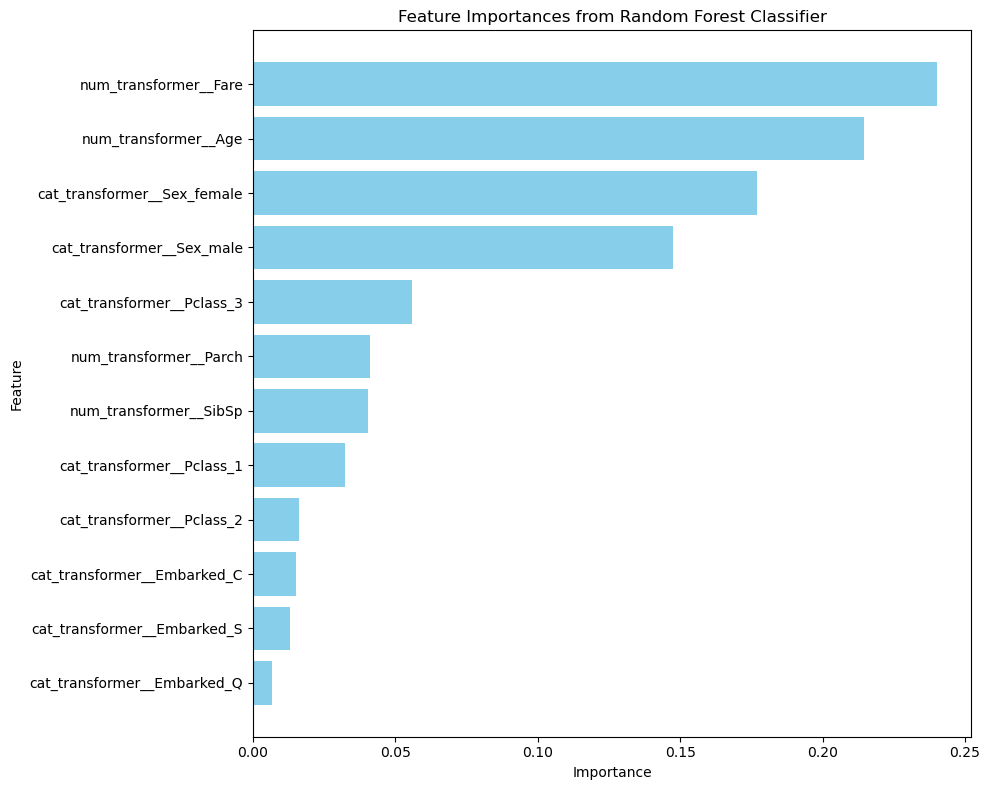

In [43]:
# Plotting the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest Classifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.tight_layout()

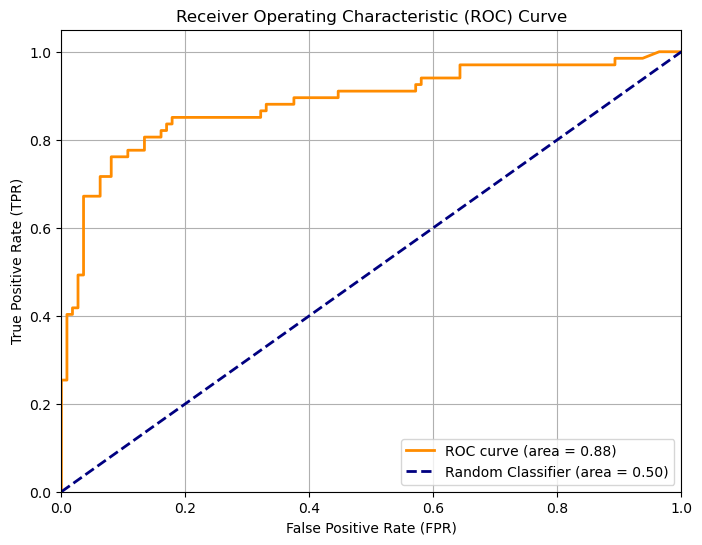

The AUC for the Random Forest Classifier is: 0.8845


In [44]:
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"The AUC for the Random Forest Classifier is: {roc_auc:.4f}")

In [45]:
# Calculate Youden's J statistic (TPR - FPR)
j_scores = tpr - fpr

# Find the index of the best threshold (maximum J score)
best_threshold_index = np.argmax(j_scores)

# The best threshold based on Youden's J
best_threshold = thresholds[best_threshold_index]
print(f"Best Threshold based on Youden's J statistic: {best_threshold}")

Best Threshold based on Youden's J statistic: 0.5582142857142858


# XGBoost

In [46]:
xgb_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic',eval_metric='mlogloss'))
])

In [47]:
# we need to add the classifier__ to denote the parameter of the classifier in the pipeline
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [48]:
grid_search_xgb.fit(X_train, y_train)

xgb_model = grid_search_xgb.best_estimator_

y_pred_xgb = xgb_model.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [49]:
accuracy = accuracy_score(y_test, y_pred_xgb)
report = classification_report(y_test, y_pred_xgb, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

report_ac['XGBoost'] = report

{'precision': 0.8225806451612904, 'recall': 0.7611940298507462, 'f1-score': 0.7906976744186046, 'support': 67.0, 'accuracy': 0.8491620111731844}


Accuracy: 0.8492

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       112
           1       0.82      0.76      0.79        67

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



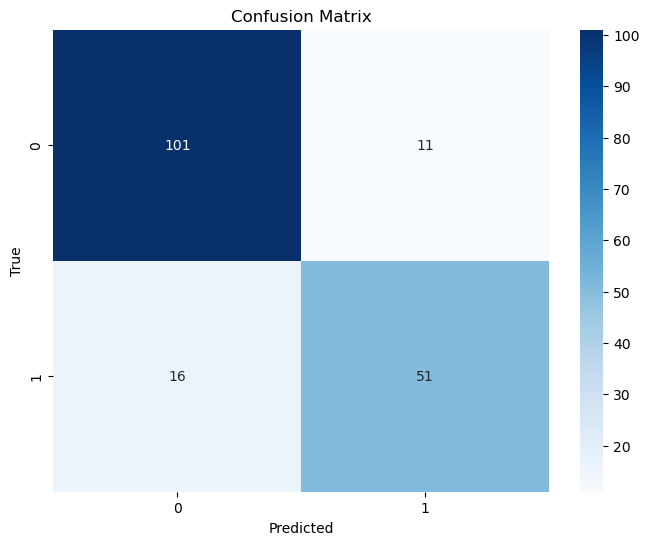

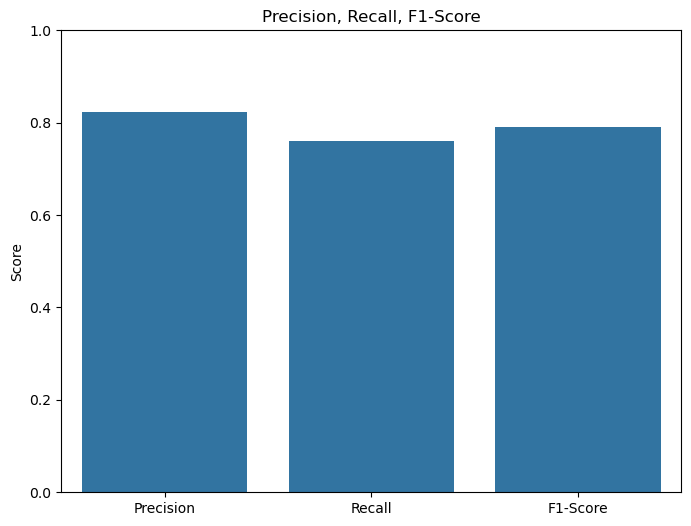

In [50]:
show_results(y_pred_xgb)

In [51]:
feature_importances= xgb_model.named_steps['classifier'].feature_importances_
features_names = xgb_model.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': features_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                        Feature  Importance
7   cat_transformer__Sex_female    0.415221
6     cat_transformer__Pclass_3    0.249954
4     cat_transformer__Pclass_1    0.112817
11  cat_transformer__Embarked_S    0.049910
1        num_transformer__SibSp    0.043132
0          num_transformer__Age    0.037110
3         num_transformer__Fare    0.032959
2        num_transformer__Parch    0.023844
9   cat_transformer__Embarked_C    0.018239
5     cat_transformer__Pclass_2    0.016815
8     cat_transformer__Sex_male    0.000000
10  cat_transformer__Embarked_Q    0.000000


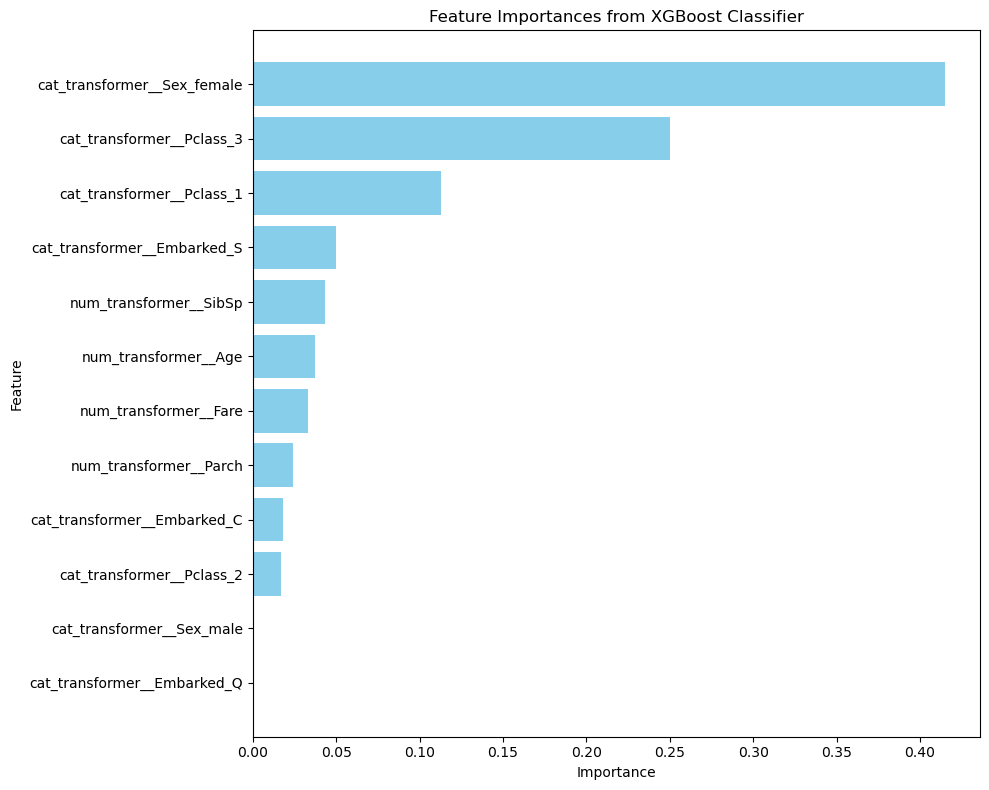

In [52]:
# Plotting the horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost Classifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.tight_layout()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

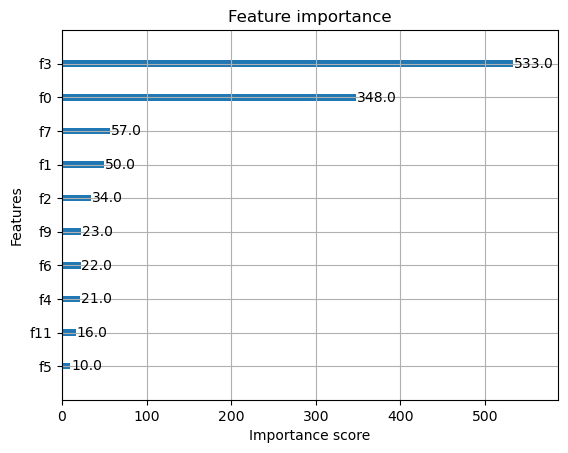

In [53]:
xgb.plot_importance(xgb_model.named_steps['classifier'])

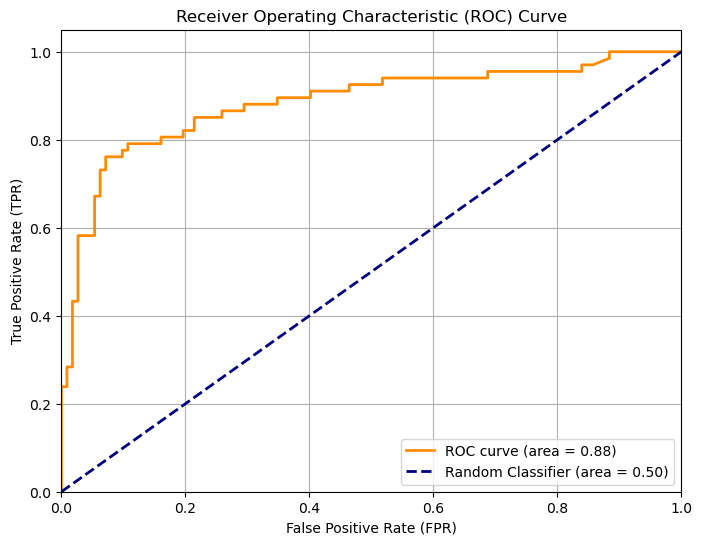

The AUC for the XGBoost Classifier is: 0.8844


In [54]:
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (area = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"The AUC for the XGBoost Classifier is: {roc_auc:.4f}")

In [55]:
# Calculate Youden's J statistic (TPR - FPR)
j_scores = tpr - fpr

# Find the index of the best threshold (maximum J score)
best_threshold_index = np.argmax(j_scores)

# The best threshold based on Youden's J
best_threshold = thresholds[best_threshold_index]
print(f"Best Threshold based on Youden's J statistic: {best_threshold}")

Best Threshold based on Youden's J statistic: 0.5893293023109436


In [56]:
results = grid_search_xgb.cv_results_

# Print out the results of the grid search (train vs validation)
print("Best parameters:", grid_search_xgb.best_params_)
print("Best cross-validation score:", grid_search_xgb.best_score_)

Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best cross-validation score: 0.7656459663936299


Top 10 Hyperparameter Combinations and their Scores:
                                               params  mean_train_score  \
63  {'classifier__colsample_bytree': 1.0, 'classif...          0.915815   
51  {'classifier__colsample_bytree': 1.0, 'classif...          0.876089   
16  {'classifier__colsample_bytree': 0.8, 'classif...          0.904774   
60  {'classifier__colsample_bytree': 1.0, 'classif...          0.876619   
20  {'classifier__colsample_bytree': 0.8, 'classif...          0.935004   
24  {'classifier__colsample_bytree': 0.8, 'classif...          0.869369   
18  {'classifier__colsample_bytree': 0.8, 'classif...          0.951763   
49  {'classifier__colsample_bytree': 1.0, 'classif...          0.844245   
17  {'classifier__colsample_bytree': 0.8, 'classif...          0.906046   
61  {'classifier__colsample_bytree': 1.0, 'classif...          0.877666   

    std_train_score  mean_test_score  std_test_score  rank_test_score  
63         0.010447         0.765646        0.021

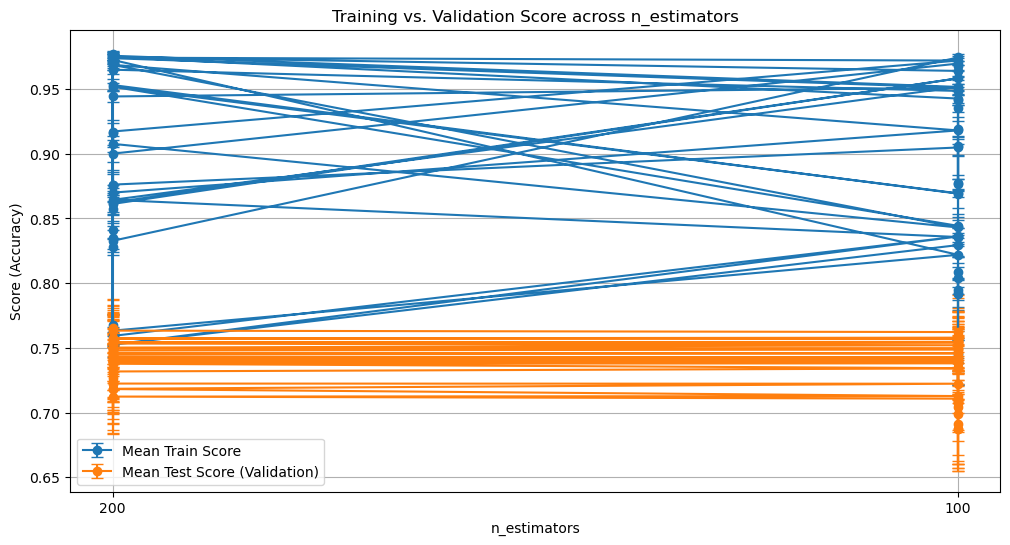

In [64]:
results = pd.DataFrame(grid_search_xgb.cv_results_)

# Sort by rank_test_score and then by mean_test_score
results = results.sort_values(by='rank_test_score')

# Display relevant columns for overfitting check
# We look at mean_train_score and mean_test_score for each parameter combination
print("Top 10 Hyperparameter Combinations and their Scores:")
print(results[['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10))

# Visualize the performance for specific hyperparameters (e.g., max_depth)
plt.figure(figsize=(12, 6))
plt.errorbar(results['param_classifier__n_estimators'].astype(str), results['mean_train_score'], yerr=results['std_train_score'], label='Mean Train Score', capsize=4, fmt='-o')
plt.errorbar(results['param_classifier__n_estimators'].astype(str), results['mean_test_score'], yerr=results['std_test_score'], label='Mean Test Score (Validation)', capsize=4, fmt='-o')
plt.xlabel('n_estimators')
plt.ylabel('Score (Accuracy)')
plt.title('Training vs. Validation Score across n_estimators')
plt.legend()
plt.grid(True)
plt.show()

Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best cross-validation score: 0.7656459663936299


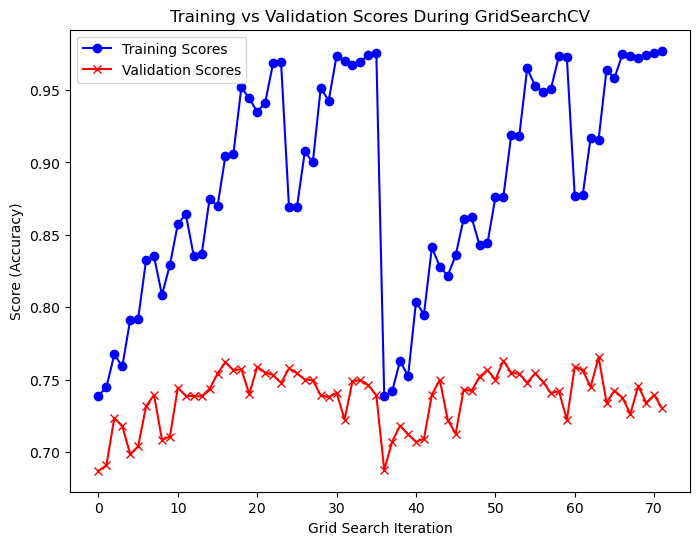

In [58]:
# Get results from the grid search
results = grid_search_xgb.cv_results_

# Print out the results of the grid search (train vs validation)
print("Best parameters:", grid_search_xgb.best_params_)
print("Best cross-validation score:", grid_search_xgb.best_score_)

# Check the training and validation scores across different hyperparameters
train_scores = results['mean_train_score']
valid_scores = results['mean_test_score']

# Plot the training vs validation scores
plt.figure(figsize=(8, 6))
plt.plot(train_scores, label='Training Scores', color='blue', marker='o')
plt.plot(valid_scores, label='Validation Scores', color='red', marker='x')
plt.xlabel('Grid Search Iteration')
plt.ylabel('Score (Accuracy)')
plt.title('Training vs Validation Scores During GridSearchCV')
plt.legend()
plt.show()

# Model Evaluation

In [59]:
report_ac

{'Naive Bayes': {'precision': 0.7,
  'recall': 0.7313432835820896,
  'f1-score': 0.7153284671532847,
  'support': 67.0,
  'accuracy': 0.7821229050279329},
 'Logistic Regression': {'precision': 0.7868852459016393,
  'recall': 0.7164179104477612,
  'f1-score': 0.75,
  'support': 67.0,
  'accuracy': 0.8212290502793296},
 'Decision Tree': {'precision': 0.7878787878787878,
  'recall': 0.7761194029850746,
  'f1-score': 0.7819548872180451,
  'support': 67.0,
  'accuracy': 0.8379888268156425},
 'Random Forest': {'precision': 0.7878787878787878,
  'recall': 0.7761194029850746,
  'f1-score': 0.7819548872180451,
  'support': 67.0,
  'accuracy': 0.8379888268156425},
 'XGBoost': {'precision': 0.8225806451612904,
  'recall': 0.7611940298507462,
  'f1-score': 0.7906976744186046,
  'support': 67.0,
  'accuracy': 0.8491620111731844}}

# Running against the real test

In [60]:
# best model
rf_model

df = pd.read_csv('tested.csv')

df['PassengerId'] = df['PassengerId'].astype('category')
df['Survived'] = df['Survived'].astype('int64')
df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']
target = 'Survived'

X = df[numerical_features + categorical_features].copy()
y = df[target].copy()

In [61]:
y_pred_rf_test = rf_model.predict(X)

In [62]:
accuracy = accuracy_score(y, y_pred_rf_test)
report = classification_report(y, y_pred_rf_test, output_dict=True)['1']
report['accuracy'] = accuracy
print(report)

{'precision': 0.8, 'recall': 0.7894736842105263, 'f1-score': 0.7947019867549668, 'support': 152.0, 'accuracy': 0.8516746411483254}


<Axes: >

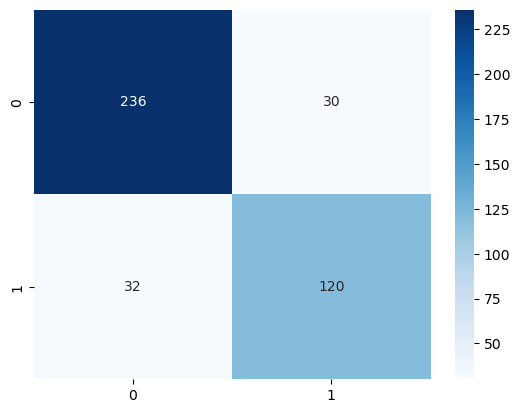

In [63]:
cm = confusion_matrix(y, y_pred_rf_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')